# Evaluate single site simulation

This script generates key information on forest structure, composition, demography and biophysical characteristics on a single site simulation

# Import modules

In [2]:
import sys
#Path to the esm_tools.py script
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools/process_output')
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import functools
import cftime
import warnings
from matplotlib.dates import DateFormatter
import math
from datetime import datetime
import esm_tools
import esm_viz
import importlib
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

# Setup

In [4]:
save_processed_output = True
pft_names = ["pine","cedar","fir","shrub","oak"]
pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen']
n_pfts = len(pft_names)
years = list(range(1900, 1962))
last_five_years = list(range(1956, 1962))

case_name = "ca_5pfts_ml_assisted_720_100123_05_-17e2acb6a_FATES-8a054a12"
inst_tag = "0002"

# Root path where case output lives
model_output_root = '/glade/scratch/adamhb/archive'

# Path if archiving didn't work
#model_output_no_archive = os.path.join(model_output_root,case_name,"run")
model_output_no_archive = '/glade/scratch/adamhb/archive/ca_5pfts_ml_assisted_720_100123_05_-17e2acb6a_FATES-8a054a12/run'

# Path to put processed output
processed_output_root = '/glade/scratch/adamhb/processed_output'
output_path_for_case = os.path.join(processed_output_root,case_name,inst_tag)
print(output_path_for_case)
if save_processed_output == True:
        # Path to store processed output (figs, tables etc.)
        esm_tools.create_directory(os.path.join(processed_output_root,case_name))
        esm_tools.create_directory(output_path_for_case)

# Constants
s_per_yr = 31536000
s_per_day = 3600 * 24
m2_per_ha = 1e4
m2_per_km2 = 1e6
g_per_kg = 1000
mm_per_m = 1000
months_per_yr = 12
s_per_month = 3600 * 24 * 30.4
W_per_kW = 1000

/glade/scratch/adamhb/processed_output/ca_5pfts_ml_assisted_720_100123_05_-17e2acb6a_FATES-8a054a12/0002
Directory '/glade/scratch/adamhb/processed_output/ca_5pfts_ml_assisted_720_100123_05_-17e2acb6a_FATES-8a054a12' already exists!
Directory '/glade/scratch/adamhb/processed_output/ca_5pfts_ml_assisted_720_100123_05_-17e2acb6a_FATES-8a054a12/0002' already exists!


# History variables

In [5]:
# define the history variables to read in
fields = [
          #have on to import these dimensions
          'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          'FATES_PATCHAREA_AP','FATES_CANOPYAREA_AP',
          'FATES_NCOHORTS','FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          'FATES_NPLANT_ACPF',
          'FATES_NPLANT_CANOPY_SZPF',
          'FATES_NPLANT_USTORY_SZPF',
          'FATES_NPLANT_RESPROUT_PF',
          #basal area
          'FATES_BASALAREA_SZPF',
          #crown_area
          'FATES_CANOPYCROWNAREA_PF',
          'FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF',
          'FATES_CANOPYAREA_HT',
          #'FATES_CROWNAREA_CLLL',
          'FATES_CROWNAREA_PF',
          #biomass
          'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          'FATES_MORTALITY_PF',
          #'FATES_MORTALITY_CANOPY_SZAP','FATES_MORTALITY_USTORY_SZAP',
          'FATES_MORTALITY_BACKGROUND_SZPF','FATES_MORTALITY_HYDRAULIC_SZPF','FATES_MORTALITY_CSTARV_SZPF',
          #'FATES_MORTALITY_IMPACT_SZPF',
          'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF',
          #'FATES_MORTALITY_CANOPY_SZ','FATES_MORTALITY_USTORY_SZ',
          'FATES_MORTALITY_SENESCENCE_SZPF',
          #seed production and recruitment
          #'FATES_SEED_PROD_USTORY_SZ','FATES_SEED_PROD_CANOPY_SZ',
          'FATES_SEEDS_IN',
          'FATES_SEED_BANK',
          'FATES_SEEDBANK_PF',
          'FATES_SEED_ALLOC_SZPF',
          'FATES_RECRUITMENT_PF',
          #GPP and NPP
          #'FATES_GPP','FATES_GPP_SZPF',
          'FATES_NPP_PF','FATES_NPP_SZPF',
          'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          #Light
          'FATES_LAISUN_Z_CLLL','FATES_LAISHA_Z_CLLL',
          'FATES_LAISUN_Z_CLLLPF','FATES_LAISHA_Z_CLLLPF',
          'FATES_PARSUN_Z_CLLLPF','FATES_PARSHA_Z_CLLLPF',
          'FATES_PARPROF_DIR_CLLL','FATES_PARPROF_DIF_CLLL',
          'FATES_PARPROF_DIF_CLLLPF','FATES_PARPROF_DIR_CLLLPF',
          #Litter
          'FATES_CWD_ABOVEGROUND_DC',
          'FATES_FUEL_AMOUNT',
          #CLM
          'QVEGT','QVEGE','QSOIL','TLAI','TBOT','RAIN','QBOT','Q2M',
          #'BTRAN',
          #H20
          'SMP',
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          'FATES_FUEL_BULKD','FATES_FUEL_SAV',
           'FATES_DISTURBANCE_RATE_FIRE',
           'FATES_FUEL_AMOUNT_AP',
           'FATES_FIRE_INTENSITY_BURNFRAC_AP',
           'FATES_BURNFRAC_AP',
           'FATES_FUEL_AMOUNT_APFC',
           'FATES_FUEL_AMOUNT',
           'FATES_FDI',
           'FATES_FIRE_INTENSITY',
           'FATES_FUELCONSUMED',
           'FATES_NESTEROV_INDEX',
           'FATES_MORTALITY_CROWNSCORCH_SZPF',
           'FATES_SCORCH_HEIGHT_APPF','FATES_FUEL_MEF',
           'FATES_FUEL_EFF_MOIST','FATES_FUEL_MOISTURE_FC','FATES_ROS'
          # 'FATES_MORTALITY_FIRE_CFLUX_PF'
          ]

# Load data

In [6]:
ds_end = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                            case_name = case_name,
                            years = last_five_years,
                            fields = fields,
                            inst_tag = inst_tag,
                            manual_path = model_output_no_archive)

-- your data have been read in -- 


# Analyze final five years of simulation

## AGB

In [7]:
print("Total AGB [kg C m-2]:",esm_tools.get_AGB(ds_end))

Total AGB [kg C m-2]: 3.2414190769195557


In [8]:
print("Total Biomass [kg C m-2]:", ds_end.FATES_VEGC_PF.sum(dim = 'fates_levpft').mean(dim = "time").values)

Total Biomass [kg C m-2]: 5.4817133


AGB units: kg m-2


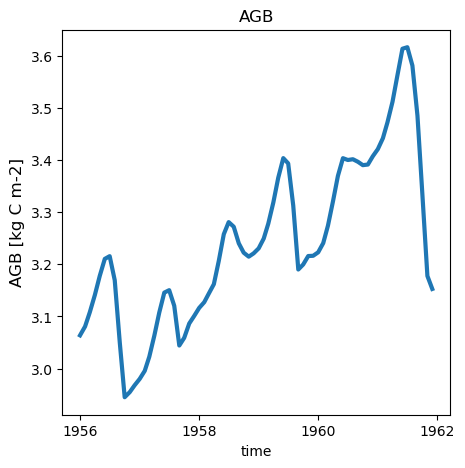

In [9]:
print("AGB units:",ds_end.FATES_VEGC_ABOVEGROUND.attrs['units'])

esm_viz.plot_array(ds_end.FATES_VEGC_ABOVEGROUND,
           xds = ds_end,
           n_pfts = n_pfts,
           title = "AGB",
           ylabel = "AGB [kg C m-2]",
           pft_colors = pft_colors,
           pft_names = pft_names,
           output_path = output_path_for_case,
           conversion = 1,
           subplots = False,
           getData = False,
           dbh_min = None)

## Canopy Height

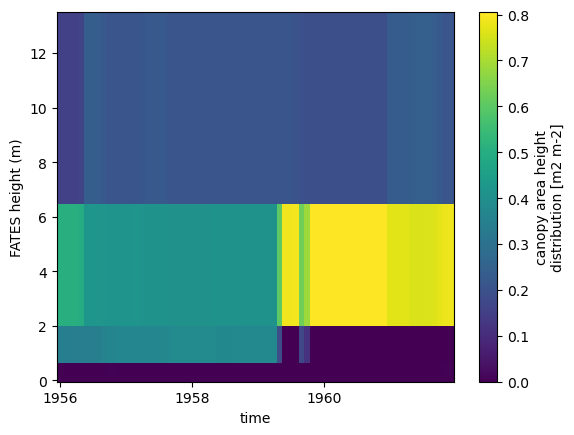

In [10]:
ds_end.FATES_CANOPYAREA_HT.plot(x = "time")

## Basal Area

In [11]:
print("Total basal area [m2 ha-1]:",np.sum(esm_tools.get_pft_level_basal_area(ds_end)))

Total basal area [m2 ha-1]: 12.969896


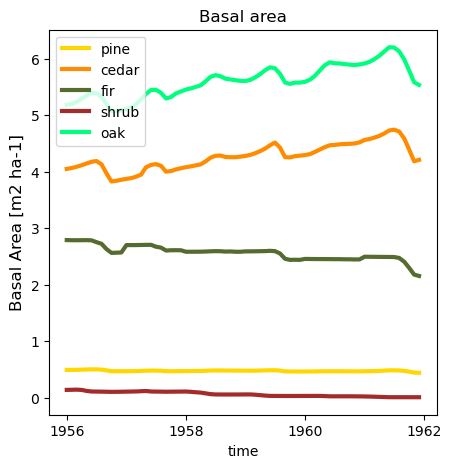

In [12]:
esm_viz.plot_array(ds_end.FATES_BASALAREA_SZPF,
           xds = ds_end,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           conversion = m2_per_ha,
           title = "Basal area",
           ylabel = "Basal Area [m2 ha-1]",
           output_path = output_path_for_case,
           subplots = False,
           getData = False,
           dbh_min = None)

### BA across size classes

In [14]:
ba_sl_pf = esm_tools.scpf_to_scls_by_pft(ds_end.FATES_BASALAREA_SZPF,ds_end)

In [21]:
ba_sl_pf.isel(time = 71, fates_levpft = 2).values

array([3.9087020e-08, 1.4974484e-08, 3.4604093e-07, 1.9446068e-06,
       1.9458408e-05, 2.0576741e-05, 4.4061831e-05, 7.5568719e-06,
       1.2481670e-06, 8.3119769e-05, 3.4279947e-05, 2.0557545e-06,
       8.4051777e-07], dtype=float32)

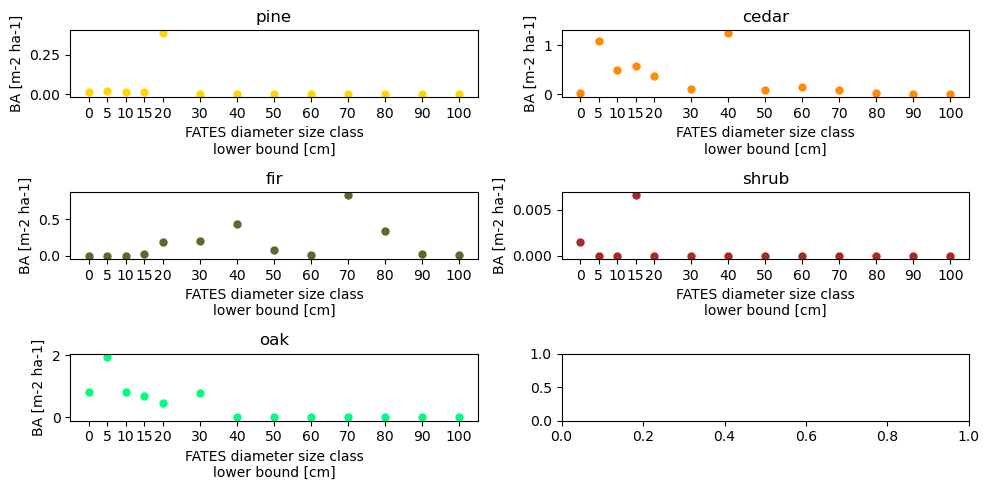

In [13]:
esm_viz.plot_size_class_distribution(ds_end,
                             n_pfts,
                             pft_colors = pft_colors,
                             pft_names = pft_names,
                             variable_type = "BA",
                             final_timestep = True,
                             specific_time_step = None,
                             conversion=m2_per_ha)

## Stem density

In [19]:
# importlib.reload(esm_tools)
# importlib.reload(esm_viz)

#### Same axis

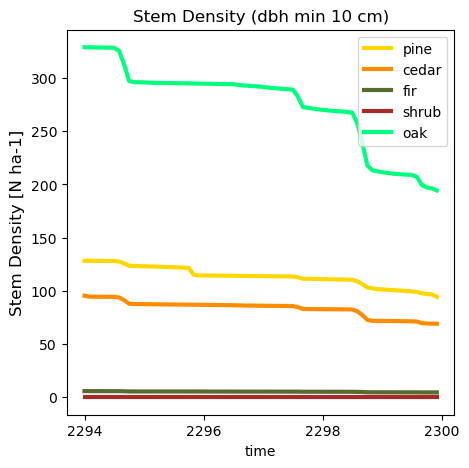

In [20]:
esm_viz.plot_array(ds_end.FATES_NPLANT_SZPF,
           xds = ds_end,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(10) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = False,
           getData = False,
           dbh_min = 10)

#### Separate axes

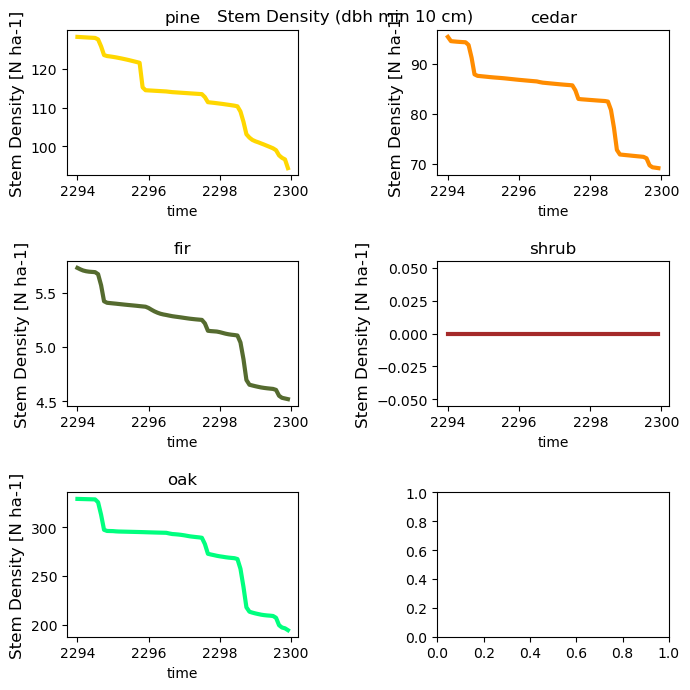

In [21]:
esm_viz.plot_array(ds_end.FATES_NPLANT_SZPF,
           xds = ds_end,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(10) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = True,
           getData = False,
           dbh_min = 10)

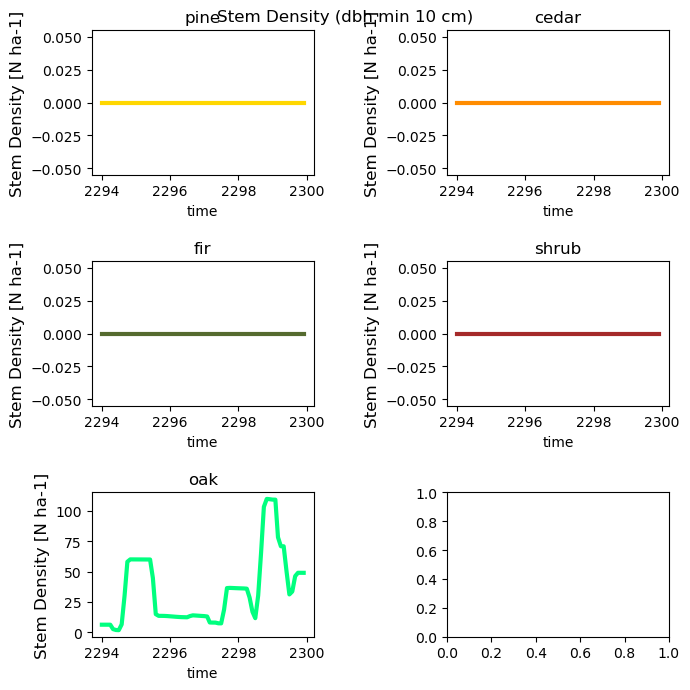

In [23]:
esm_viz.plot_array(ds_end.FATES_NPLANT_RESPROUT_PF,
           xds = ds_end,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(10) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = True,
           getData = False,
           dbh_min = 10)

### Stem density across size classes (dbh min = 10 cm)

In [25]:
den_sl_pf = esm_tools.scpf_to_scls_by_pft(ds_end.FATES_NPLANT_SZPF,ds_end)
den_sl_pf.isel(time = 71, fates_levpft = 2).values

array([1.6890268e-04, 3.0550073e-06, 2.8322376e-05, 8.6104650e-05,
       4.8132616e-04, 1.8778670e-04, 2.7071542e-04, 3.2289350e-05,
       3.5081189e-06, 1.8533510e-04, 5.6937064e-05, 3.1590243e-06,
       1.0464696e-06], dtype=float32)

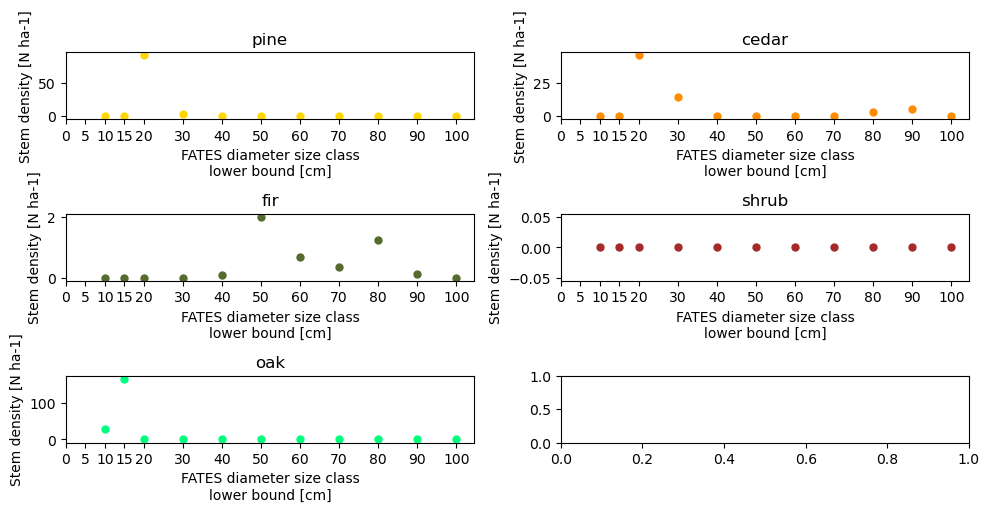

In [24]:
esm_viz.plot_size_class_distribution(ds_end,
                             n_pfts,
                             pft_colors = pft_colors,
                             pft_names = pft_names,
                             variable_type = "Stem density",
                             final_timestep = True,
                             specific_time_step = None,
                             conversion=m2_per_ha, dbh_min = 10)

## Crown area

### Canopy crown area

Text(0.5, 0, 'year')

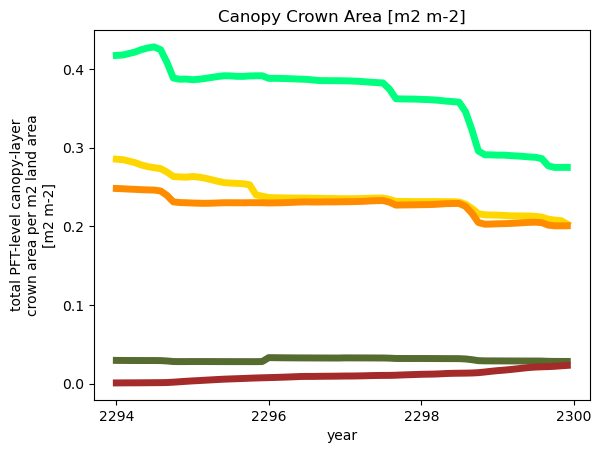

In [25]:
for p in range(n_pfts):
    ds_end.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Canopy Crown Area [m2 m-2]")
plt.xlabel("year")

### Crown area (canopy and understory)

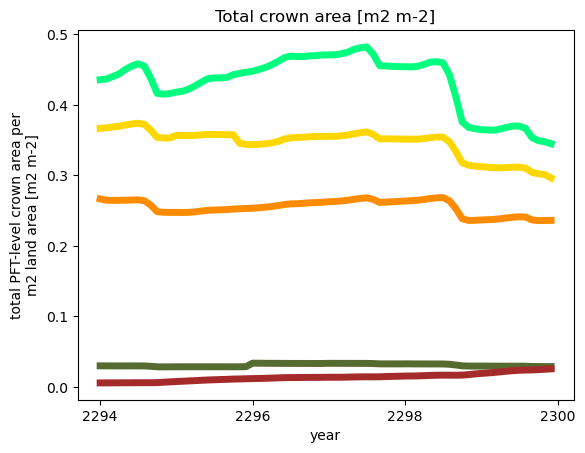

In [26]:
for p in range(n_pfts):
    ds_end.FATES_CROWNAREA_PF.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Total crown area [m2 m-2]")
plt.xlabel("year")
plt.show()

### Fraction of total crown area in canopy

Text(0.5, 0, 'year')

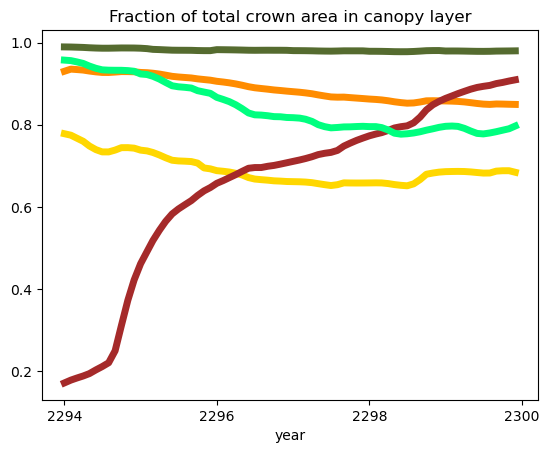

In [27]:
frac_in_canopy = esm_tools.frac_in_canopy(ds_end)
for p in range(n_pfts):
    frac_in_canopy.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Fraction of total crown area in canopy layer")
plt.xlabel("year")

In [28]:
# importlib.reload(esm_tools)
# importlib.reload(esm_viz)

### Crown area by patch age

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


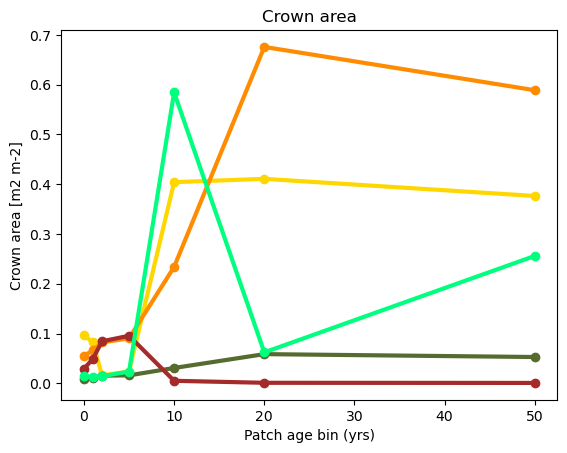

In [29]:
esm_viz.cca_by_patch_age(ds_end,
                         n_pfts = n_pfts,
                         pft_colors = pft_colors,
                         pft_names = pft_names,
                         canopy_crown_area = False)

### Canopy crown area by patch age

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


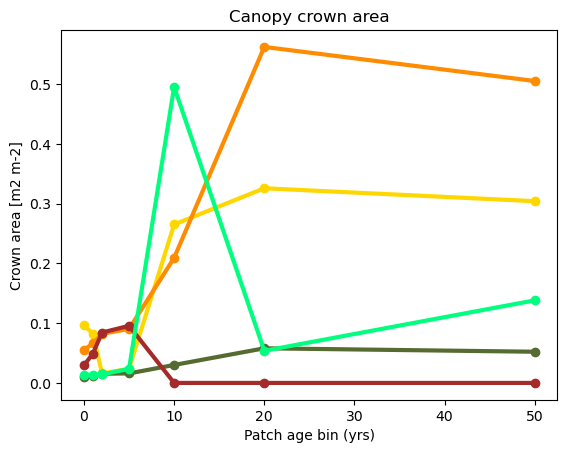

In [30]:
esm_viz.cca_by_patch_age(ds_end,n_pfts = n_pfts,
                          pft_colors = pft_colors,
                          pft_names = pft_names,canopy_crown_area = True)

## NPP

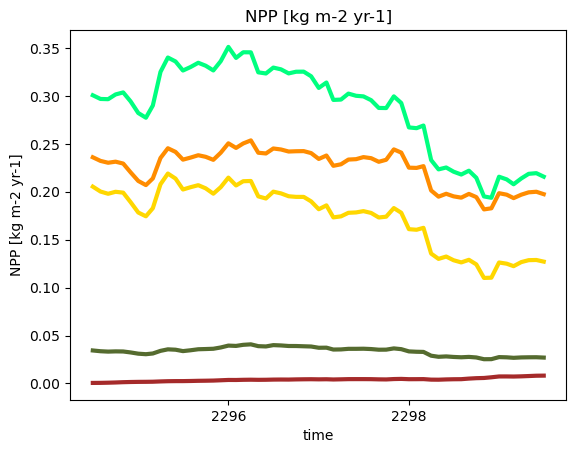

In [31]:
for p in range(n_pfts):
    mv_avg = ds_end.FATES_NPP_PF.isel(fates_levpft=p).rolling(time=12, center=True).mean()\
    * s_per_yr
    mv_avg.plot(x = "time", color = pft_colors[p],lw = 3)

plt.ylabel("NPP [kg m-2 yr-1]")
plt.title("NPP [kg m-2 yr-1]")
plt.show()

## Recruitment

### Per area [N ha-1]

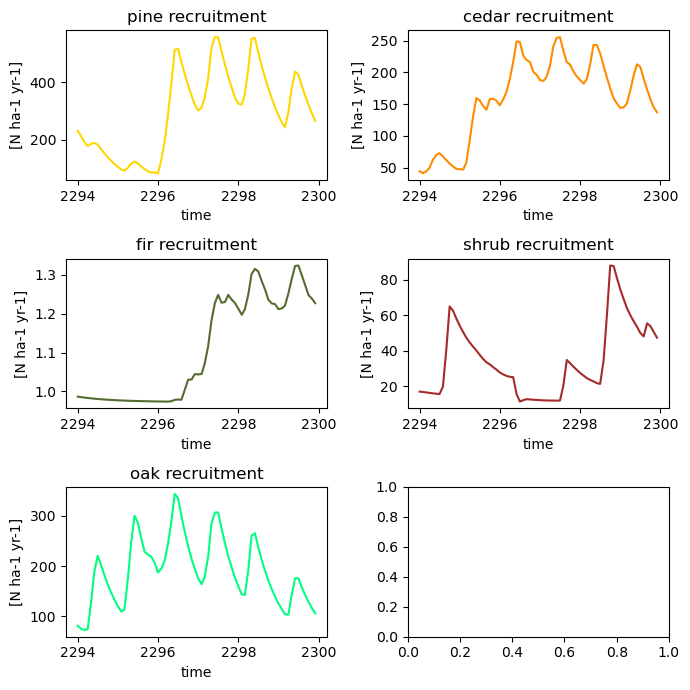

In [32]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    rec = ds_end.FATES_RECRUITMENT_PF.isel(fates_levpft=p) * m2_per_ha
    rec.plot(x = "time", color = pft_colors[p], ax=ax)
    ax.set_ylabel("[N ha-1 yr-1]")
    ax.set_title('{} recruitment'.format(pft_names[p]))
    
plt.tight_layout()

### Per unit basal area [N / m2 basal area]

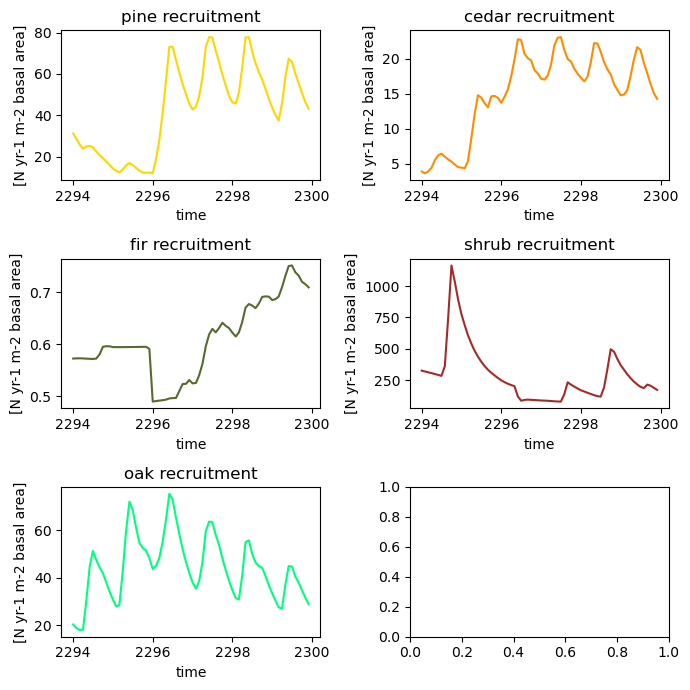

In [33]:
basal_area_pf = esm_tools.scpf_to_scls_by_pft(ds_end.FATES_BASALAREA_SZPF,ds_end)
basal_area_pf = basal_area_pf.sum(dim = "fates_levscls")

rec_per_cap = ds_end.FATES_RECRUITMENT_PF / basal_area_pf

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    rec = rec_per_cap.isel(fates_levpft=p)
    rec.plot(x = "time", color = pft_colors[p], ax=ax)
    ax.set_ylabel("[N yr-1 m-2 basal area]")
    ax.set_title('{} recruitment'.format(pft_names[p]))
    
plt.tight_layout()

## Seed bank

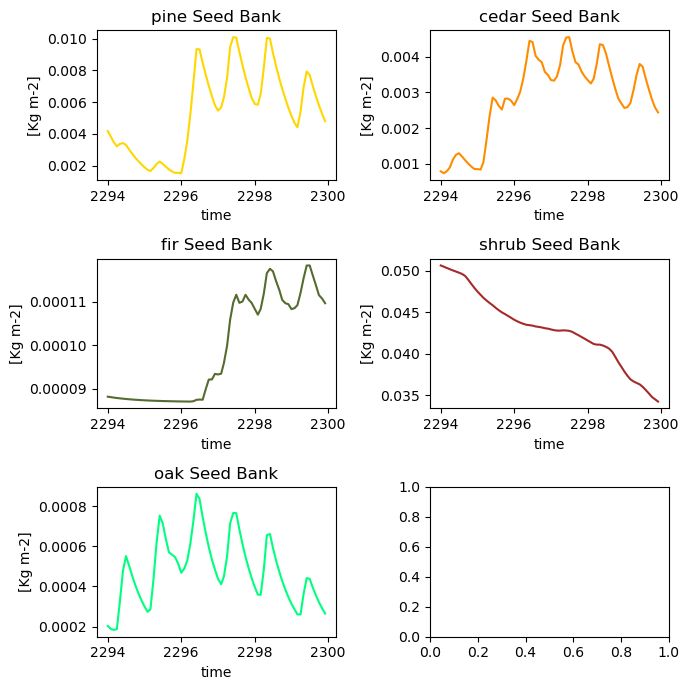

In [34]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    seed = ds_end.FATES_SEEDBANK_PF.isel(fates_levpft=p)
    seed.plot(x = "time", color = pft_colors[p], ax=ax)
    ax.set_ylabel("[Kg m-2]")
    ax.set_title('{} Seed Bank'.format(pft_names[p]))
    
plt.tight_layout()

## Fuel loads

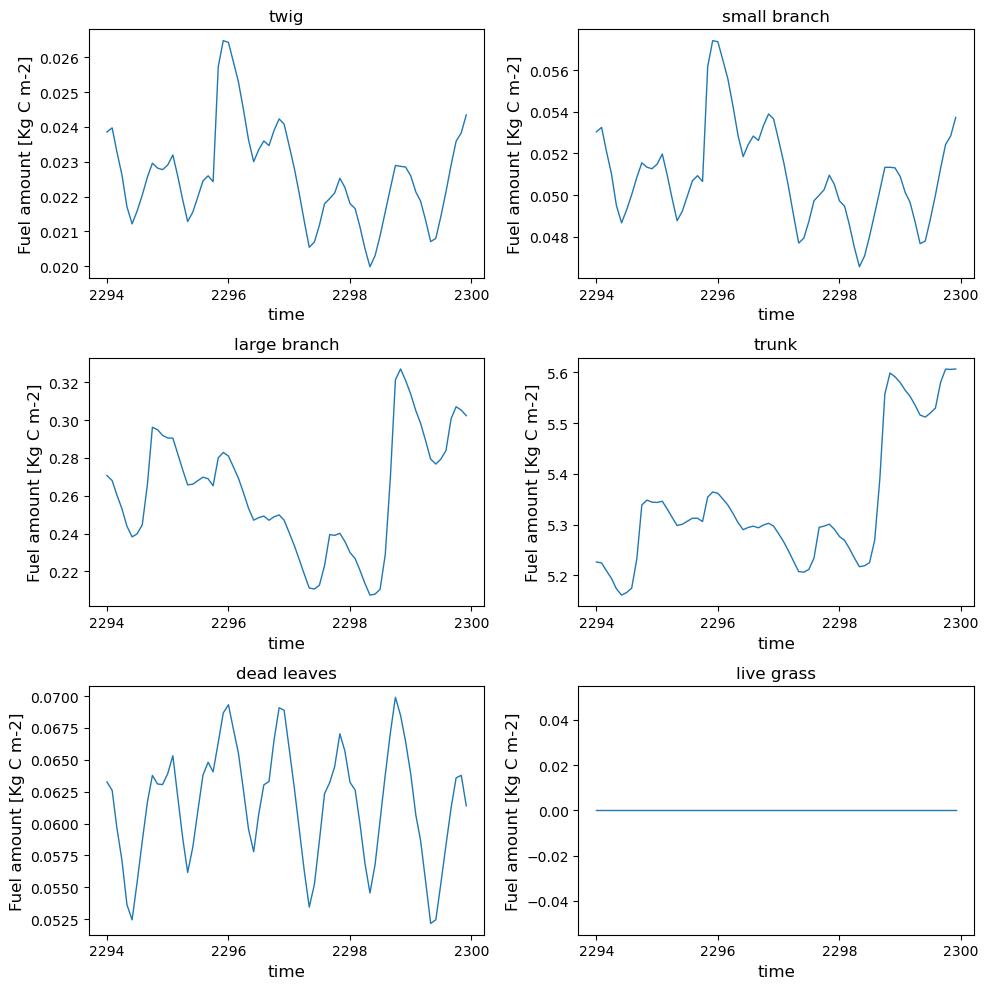

In [35]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize':'large'})

age_by_fuel = esm_tools.agefuel_to_age_by_fuel(ds_end.FATES_FUEL_AMOUNT_APFC,ds_end)
fates_fuel_amount_by_class = age_by_fuel.sum(dim = "fates_levage")

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(10,10), sharey = False)

fuel_class_names = ['twig','small branch','large branch','trunk','dead leaves','live grass']

for p,ax in zip(range(6),axes.ravel()):
    fates_fuel_amount_by_class.isel(fates_levfuel=p).plot(x = "time",lw = 1, ax = ax)
    ax.set_ylabel("Fuel amount [Kg C m-2]")
    ax.set_title(fuel_class_names[p])
    
plt.tight_layout()

### Combustible fuel total

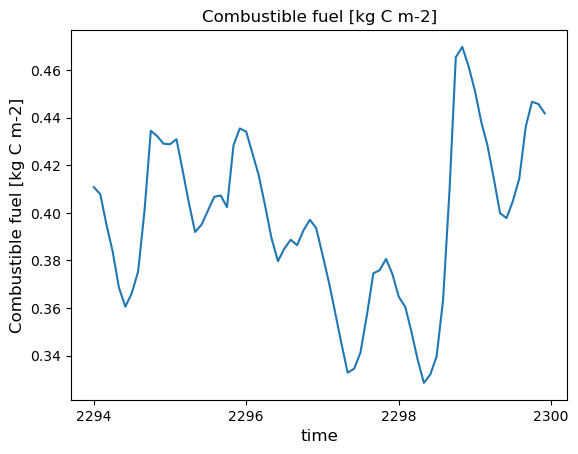

In [36]:
fates_trunk_fuel_amount = fates_fuel_amount_by_class.isel(fates_levfuel = 3)
fates_combustible_fuel_amount = fates_fuel_amount_by_class.sum(dim = "fates_levfuel") - fates_trunk_fuel_amount
fates_combustible_fuel_amount.plot()
plt.ylabel("Combustible fuel [kg C m-2]")
plt.title("Combustible fuel [kg C m-2]")
plt.show()

## Fuel moisture

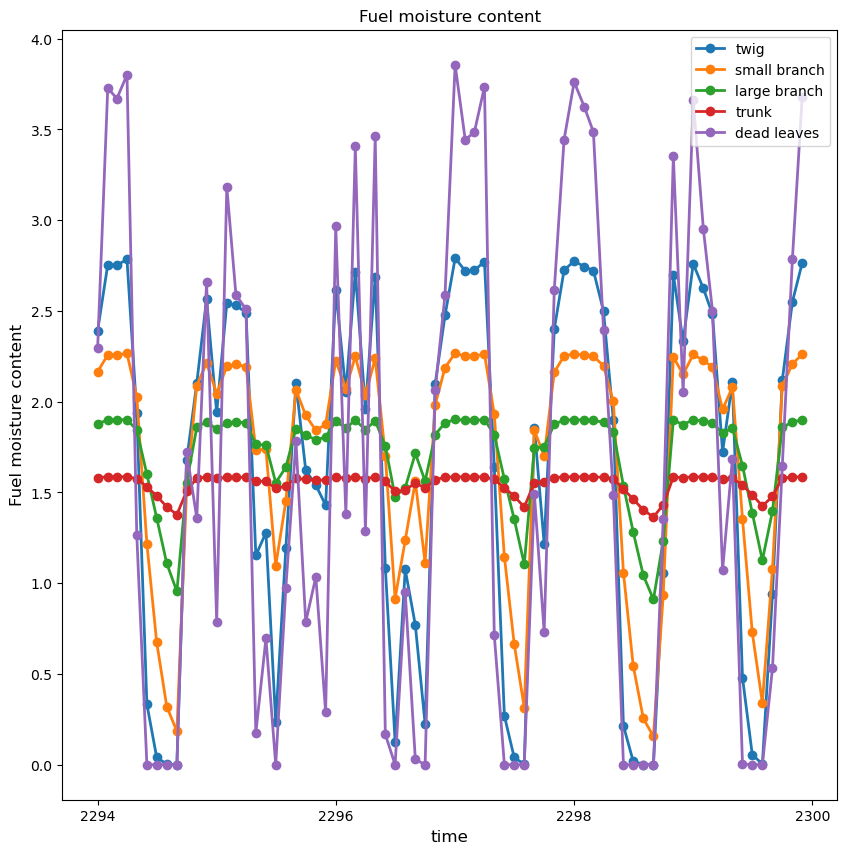

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize':'large'})

fuel_class_names = ['twig','small branch','large branch','trunk','dead leaves']

#plot pft-level basal area over time
for i,fc in enumerate(fuel_class_names):
    fmc = ds_end.FATES_FUEL_MOISTURE_FC.isel(fates_levfuel=i)
    fmc.plot(x = "time", label = fc,lw = 2, add_legend = True, marker = "o")

plt.legend()
plt.ylabel('Fuel moisture content', fontsize=12)
plt.title('Fuel moisture content')
plt.show()

## Soil moisture

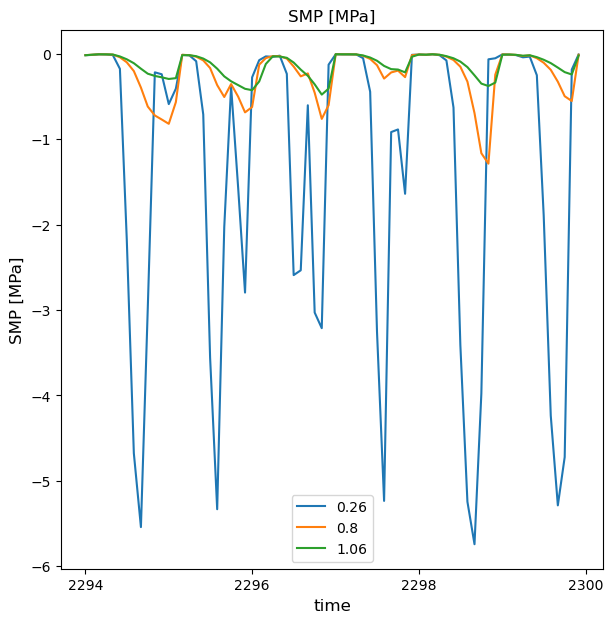

In [38]:
esm_viz.plot_smp(ds_end.SMP,ds_end,output_path=output_path_for_case)

# Full dataset

In [39]:
# define the history variables to read in
full_time_series_fields = [
          #have on to import these dimensions
          'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          'FATES_PATCHAREA_AP',
          'FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          #basal area
          'FATES_BASALAREA_SZPF',
          #crown_area
          'FATES_CANOPYCROWNAREA_PF',
          'FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF',
          'FATES_CROWNAREA_PF',
          #biomass
          #'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          #'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          'FATES_MORTALITY_PF',
          #'FATES_MORTALITY_CANOPY_SZAP','FATES_MORTALITY_USTORY_SZAP',
          'FATES_MORTALITY_BACKGROUND_SZPF','FATES_MORTALITY_HYDRAULIC_SZPF','FATES_MORTALITY_CSTARV_SZPF',
          'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF',
          'FATES_MORTALITY_SENESCENCE_SZPF','FATES_MORTALITY_TERMINATION_SZPF','FATES_MORTALITY_LOGGING_SZPF',
          'FATES_MORTALITY_FREEZING_SZPF','FATES_MORTALITY_AGESCEN_SZPF','FATES_MORTALITY_IMPACT_SZPF',
          #seed production and recruitment
          #GPP and NPP
          'FATES_NPP_PF','FATES_NPP_SZPF',
          'FATES_RECRUITMENT_PF',
          #'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          'SMP',
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          'FATES_FUEL_BULKD','FATES_FUEL_SAV',
          'FATES_FUEL_AMOUNT_AP',
          'FATES_FIRE_INTENSITY_BURNFRAC_AP',
          'FATES_BURNFRAC_AP',
          'FATES_NESTEROV_INDEX',
          'FATES_VEGC_ABOVEGROUND'
          ]

## Load the full dataset

In [40]:
ds = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                            case_name = case_name,
                            years = years,
                            fields = full_time_series_fields,
                            inst_tag = inst_tag)#,
                            #manual_path = model_output_no_archive)

-- your data have been read in -- 


## AGB

AGB units: kg m-2


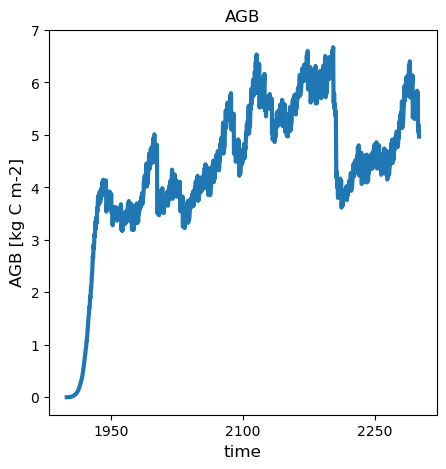

In [41]:
print("AGB units:",ds.FATES_VEGC_ABOVEGROUND.attrs['units'])

esm_viz.plot_array(ds.FATES_VEGC_ABOVEGROUND,
           xds = ds,
           n_pfts = n_pfts,
           title = "AGB",
           ylabel = "AGB [kg C m-2]",
           pft_colors = pft_colors,
           pft_names = pft_names,
           output_path = output_path_for_case,
           conversion = 1,
           subplots = False,
           getData = False,
           dbh_min = None)

## Burned area

In [42]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

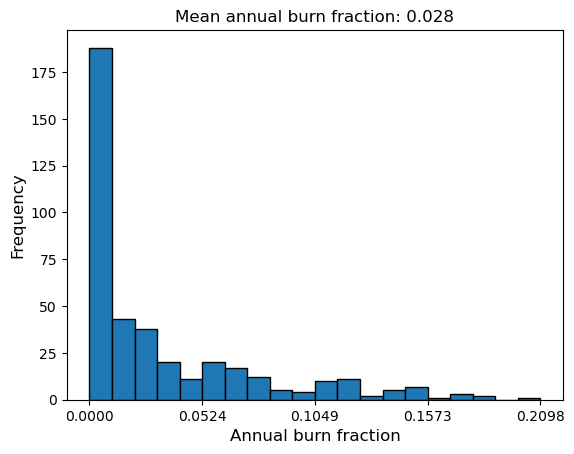

In [43]:
esm_viz.plot_mean_annual_burn_frac(ds,start_date="1950-01-01",end_date="1999-01-01")

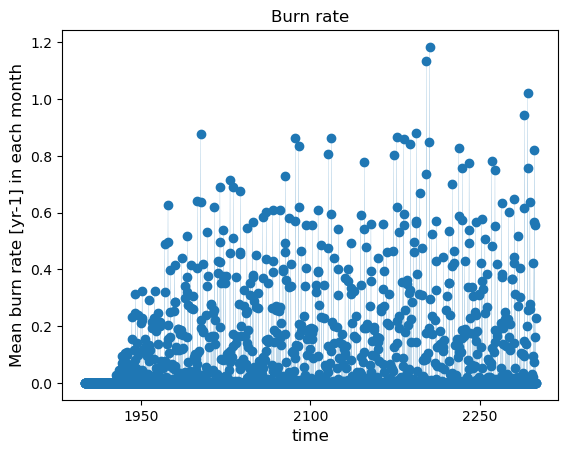

In [44]:
burnfrac = ds.FATES_BURNFRAC  * s_per_yr
burnfrac.plot(lw = 0.1, marker = "o")
plt.ylabel('Mean burn rate [yr-1] in each month', fontsize=12)
plt.title('Burn rate')
plt.show()

## Area-weighted fire intensity over time

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


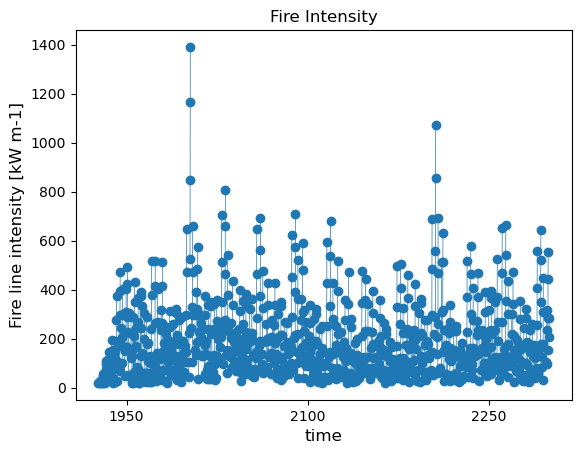

In [45]:
esm_viz.plot_area_weighted_fire_intensity(ds)

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


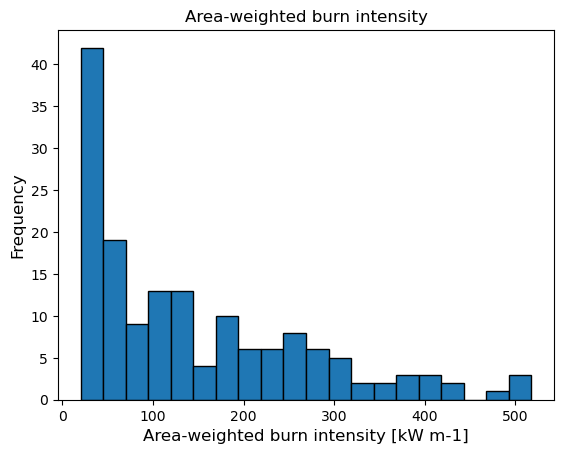

In [46]:
esm_viz.plot_awfi_hist(ds,start_date="1950-01-01",end_date="1999-01-01")

## Stem density

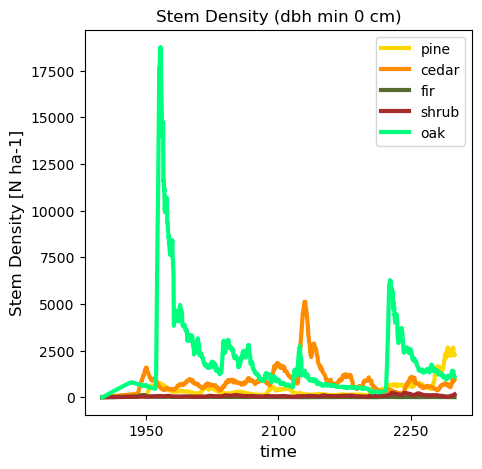

In [47]:
esm_viz.plot_array(ds.FATES_NPLANT_SZPF,
           xds = ds,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(0) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = False,
           getData = False,
           dbh_min = 0)

## Basal area

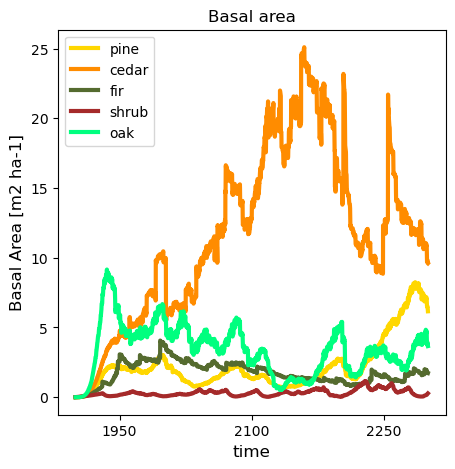

In [48]:
esm_viz.plot_array(ds.FATES_BASALAREA_SZPF,
           xds = ds,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           conversion = m2_per_ha,
           title = "Basal area",
           ylabel = "Basal Area [m2 ha-1]",
           output_path = output_path_for_case,
           subplots = False,
           getData = False,
           dbh_min = None)

## Recruitment

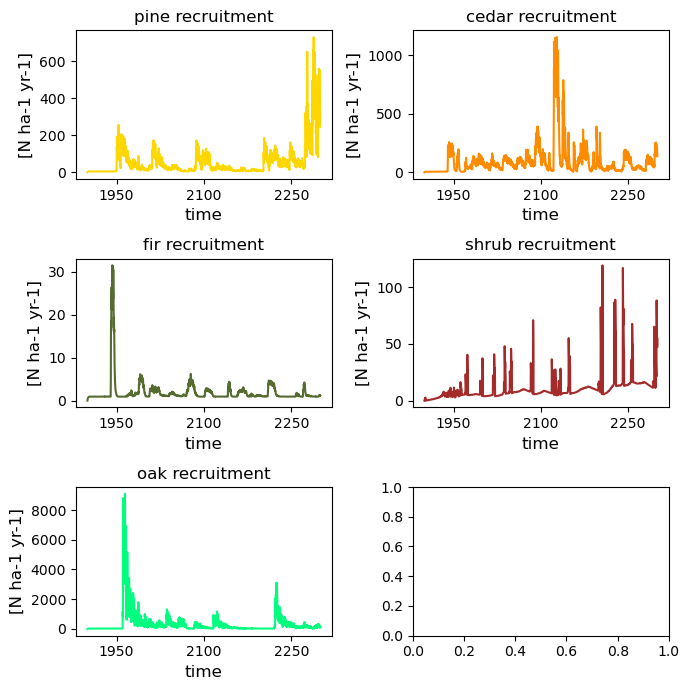

In [49]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    rec = ds.FATES_RECRUITMENT_PF.isel(fates_levpft=p) * m2_per_ha
    rec.plot(x = "time", color = pft_colors[p], ax=ax)
    ax.set_ylabel("[N ha-1 yr-1]")
    ax.set_title('{} recruitment'.format(pft_names[p]))
    
plt.tight_layout()

## NPP

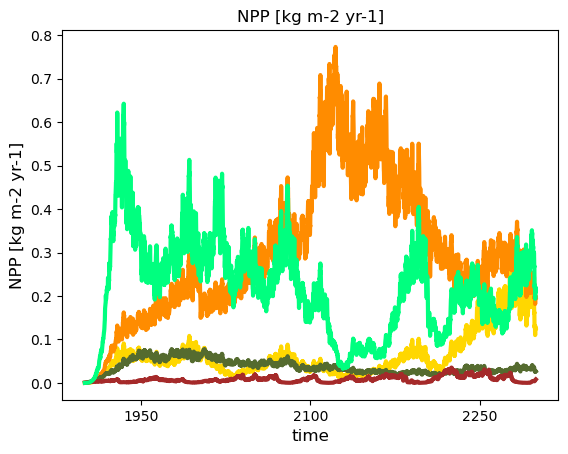

In [50]:
for p in range(n_pfts):
    mv_avg = ds.FATES_NPP_PF.isel(fates_levpft=p).rolling(time=12, center=True).mean()\
    * s_per_yr
    mv_avg.plot(x = "time", color = pft_colors[p],lw = 3)

plt.ylabel("NPP [kg m-2 yr-1]")
plt.title("NPP [kg m-2 yr-1]")
plt.show()

## NPP per unit basal area

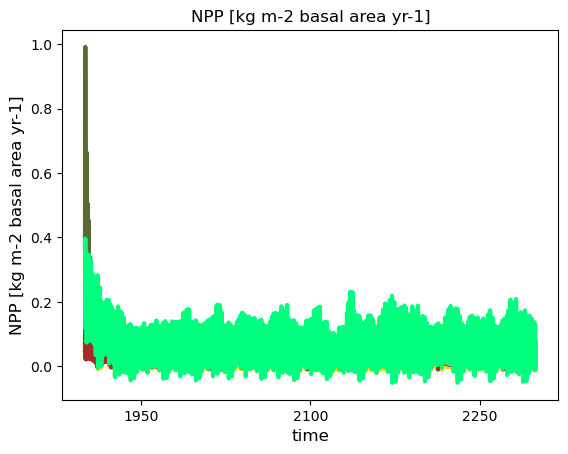

In [51]:
basal_area_pf = esm_tools.scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF,ds)
basal_area_pf = basal_area_pf.sum(dim = "fates_levscls") * m2_per_ha

npp = ds.FATES_NPP_PF * s_per_yr

NPP_per_unit_ba = npp / basal_area_pf

for p in range(n_pfts):
    #mv_avg = NPP_per_unit_ba.isel(fates_levpft=p).rolling(time=12, center=True).mean()\
    #* s_per_yr
    #basal_area_pf.isel(fates_levpft=p).plot(x = "time", color = pft_colors[p],lw = 3)
    NPP_per_unit_ba.isel(fates_levpft=p).plot(x = "time", color = pft_colors[p],lw = 3)
    
    #mv_avg.plot(x = "time", color = pft_colors[p],lw = 3)

plt.ylabel("NPP [kg m-2 basal area yr-1]")
plt.title("NPP [kg m-2 basal area yr-1]")
plt.show()

## Per capita mortality rates

In [52]:
# yrs_per_month = 1/12

# #Plot mortality rates
# mort_types = (ds.FATES_MORTALITY_PF, ds.FATES_MORTALITY_BACKGROUND_SZPF,
#               ds.FATES_MORTALITY_HYDRAULIC_SZPF, ds.FATES_MORTALITY_CSTARV_SZPF,
#               ds.FATES_MORTALITY_FIRE_SZPF,ds.FATES_MORTALITY_SENESCENCE_SZPF,
#               ds.FATES_MORTALITY_TERMINATION_SZPF,ds.FATES_MORTALITY_LOGGING_SZPF,
#               ds.FATES_MORTALITY_FREEZING_SZPF,ds.FATES_MORTALITY_AGESCEN_SZPF,ds.FATES_MORTALITY_IMPACT_SZPF)

# # Get per capita mortality rates
# m_total, m_back, m_hydr, m_cstarv, m_fire, m_sen, m_term, m_log, m_freeze, m_agescen, m_impact = map(functools.partial(esm_tools.per_capita_rate,
#                                            xds = ds, unit_conversion = 1),mort_types)
# morts = (m_total, m_back, m_hydr, m_cstarv, m_fire, m_sen, m_term, m_log, m_freeze, m_agescen, m_impact)

# mort_titles = ["Total Mortality Rate","Background Mortality Rate","Hydraulic Failure Mortality",
# "Carbon Starvation Mortality","Fire Mortality","Senescence Mortality","Termination Mortality",
# "Logging Mortality", "Freezing Mortality","AGESEN Mortality","Impact Mortality"]

# for i in range(len(mort_titles)):
#     esm_viz.plot_array(xarr=morts[i],xds=ds,n_pfts=n_pfts,
#                        pft_colors=pft_colors,
#                        pft_names = pft_names,
#                        title = mort_titles[i],
#                        ylabel='[N per capita month-1]',
#                        output_path=output_path_for_case,subplots=True)

In [53]:
# esm_viz.plot_array(xarr=m_fire,xds=ds,n_pfts=n_pfts,
#                        pft_colors=pft_colors,
#                        pft_names = pft_names,
#                        title = mort_titles[i],
#                        ylabel='[N per capita month-1]',
#                        output_path=output_path_for_case,subplots=True)

## Per-area mortality rates

In [54]:
# morts = (ds.FATES_MORTALITY_PF, ds.FATES_MORTALITY_BACKGROUND_SZPF,
#               ds.FATES_MORTALITY_HYDRAULIC_SZPF, ds.FATES_MORTALITY_CSTARV_SZPF,
#               ds.FATES_MORTALITY_FIRE_SZPF,ds.FATES_MORTALITY_SENESCENCE_SZPF,
#               ds.FATES_MORTALITY_TERMINATION_SZPF,ds.FATES_MORTALITY_LOGGING_SZPF,
#               ds.FATES_MORTALITY_FREEZING_SZPF,ds.FATES_MORTALITY_AGESCEN_SZPF,ds.FATES_MORTALITY_IMPACT_SZPF)

# mort_titles = ["Total Mortality Rate","Background Mortality Rate","Hydraulic Failure Mortality",
# "Carbon Starvation Mortality","Fire Mortality","Senescence Mortality","Termination Mortality",
# "Logging Mortality", "Freezing Mortality","AGESEN Mortality","Impact Mortality"]

# for i in range(len(mort_titles)):
#     esm_viz.plot_array(xarr=morts[i],xds=ds,n_pfts=n_pfts,
#                        pft_colors=pft_colors,
#                        pft_names = pft_names,
#                        title = mort_titles[i],
#                        ylabel='[N ha-1 yr-1]',
#                        output_path=output_path_for_case,
#                        conversion=m2_per_ha,
#                        subplots=True)